**Train and test an autoencoder for a particular type of histogram**  
At this stage all of the available data (per year) is used to train the autoencoder.  
For the case where only a small subset of the data is used for training, see autoencoder_iterative.

In [1]:
### imports

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
# external modules
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
import importlib
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import h5py

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
importlib.reload(csvu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)

Using TensorFlow backend.
/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<module 'generate_data_utils' from '../utils/generate_data_utils.py'>

In [2]:
plotNames = 'All_Inner_and_outer_test'
name = plotNames+'plots'
### read and select data

#df = csvu.read_csv('DF2017_size_PXLayer_2.csv')


In [3]:
#cell for multiple histos "appended"
df1 = csvu.read_and_merge_csv(['DF2017B_chargeInner_PXLayer_1.csv','DF2017B_chargeInner_PXLayer_2.csv','DF2017B_chargeInner_PXLayer_3.csv','DF2017B_chargeInner_PXLayer_4.csv','DF2017B_chargeOuter_PXLayer_1.csv','DF2017B_chargeOuter_PXLayer_2.csv','DF2017B_chargeOuter_PXLayer_3.csv','DF2017B_chargeOuter_PXLayer_4.csv' ], histnames=[], runnbs=[])
df1 = dfu.merge_ls(df1)
df1.reset_index(drop=True,inplace=True)
#dfu.get_runs(df1)
#,  
#print('raw input data shape: {}'.format( dfu.get_hist_values(df)[0].shape))


INFO in csv_utils.py / read_and_merge_csv: reading and merging 8 csv files...
  - now processing file 1 of 8...
  - now processing file 2 of 8...
  - now processing file 3 of 8...
  - now processing file 4 of 8...
  - now processing file 5 of 8...
  - now processing file 6 of 8...
  - now processing file 7 of 8...
  - now processing file 8 of 8...


In [4]:
### filtering: select only DCS-bin on data and filter out low statistics
#print(df['histo'][1])

df2 = dfu.select_runs(df1,[297057, 297099, 297101, 297113, 297114, 297175, 297177, 297179, 297215, 297218, 297225, 297296, 297411, 297426, 297431, 297434, 297468, 297483, 297486, 297503, 297557, 297598, 297604, 297620, 297659, 297670, 297674, 297678, 297722, 298997, 299061, 299065, 299067, 299096, 299149, 299178, 299184, 299185, 299327, 299329, 299480])
                      #[297050,  297474,299000, 299917]
df2 = dfu.select_dcson(df2)
print('number of passing lumisections after DCS selection: {}'.format( len(df2) ))

df2 = dfu.select_highstat(df2,entries_to_bins_ratio=100)
print('number of passing lumisections after high statistics selection: {}'.format( len(df2) ))

number of passing lumisections after DCS selection: 10631
number of passing lumisections after high statistics selection: 10530


(10530, 816)
size of training set: (10530, 816)


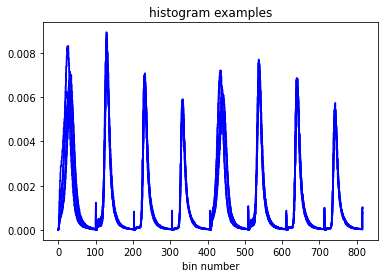

In [5]:
### preprocessing of the data: rebinning and normalizing

rebinningfactor = 1

X_train = hu.preparedatafromdf(df2,rebinningfactor=rebinningfactor,donormalize=True,doplot=True)
print(str(X_train.shape))
(ntrain,nbins) = X_train.shape
print('size of training set: '+str(X_train.shape))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 408)               333336    
_________________________________________________________________
dense_13 (Dense)             (None, 816)               333744    
Total params: 667,080
Trainable params: 667,080
Non-trainable params: 0
_________________________________________________________________
(10530, 816)
Epoch 1/200
474/474 [==============================] - 2s 4ms/step - loss: 3.8530e-06 - val_loss: 2.0103e-06
Epoch 2/200
474/474 [==============================] - 2s 4ms/step - loss: 1.7371e-06 - val_loss: 1.3750e-06
Epoch 3/200
474/474 [==============================] - 2s 4ms/step - loss: 1.1828e-06 - val_loss: 9.7216e-07
Epoch 4/200
474/474 [==============================] - 2s 3ms/step - loss: 1.2266e-06 - val_loss: 8.6184e-07
Epoch 5/200
474/474 [==============================] - 2s 4ms

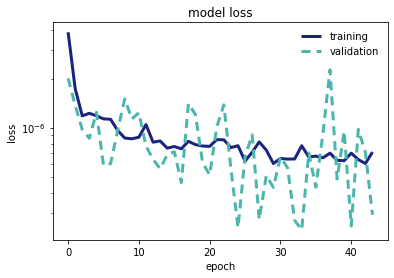

INFO:tensorflow:Assets written to: All_Inner_and_outer_test/assets


In [61]:
### build the model and train it, or load an already saved model

# choose whether to train new model or load one 
trainnew = True
savemodel = True
modelname = plotNames

# imports
from keras.models import load_model

# case 1: train new model
if trainnew:
    
    input_size = X_train.shape[1]
    arch = [int(X_train.shape[1]/2.)]
    act = ['tanh']*len(arch)
    opt = 'adam'
    loss = aeu.mseTop10
    autoencoder = aeu.getautoencoder(input_size,arch,act,opt,loss)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    print(str(X_train.shape))
    history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=20, shuffle=True, verbose=1, validation_split=0.1, callbacks=[callback])
    plot = pu.plot_loss(history, title = 'model loss')
    
    plt.savefig(name+'_loss.png')
    plt.show()
    
   

    if savemodel: autoencoder.save(modelname)
    
# case 2: load existing model
else:
   
    autoencoder = load_model(modelname+'/saved_model.pb',custom_objects={'mseTop10': aeu.mseTop10})
    
    
    

In [62]:
### evaluate the model on the training set

predictionTrain = autoencoder.predict(X_train)
mseTrain = aeu.mseTop10Raw(X_train, predictionTrain)
print(predictionTrain.shape)

(10530, 816)


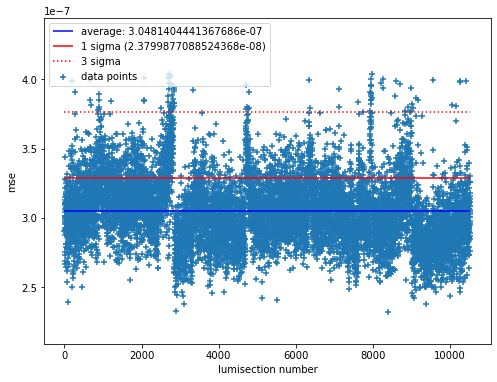

mean mse: 3.0481404441367686e-07
std mse: 2.3799877088524368e-08


In [63]:
### plot the global MSE trend

plot = pu.plot_mse(mseTrain,rmlargest=0.01)

plot[1].legend()
plt.savefig(name+'_mse.png', bbox_inches="tight")

plt.show()


(mean,std) = pu.plot_mse(mseTrain,doplot=False,rmlargest=0.01)
print('mean mse: {}'.format(mean))
print('std mse: {}'.format(std))

The mse threshold is: 3.7621367567924996e-07
Number of passing histograms: 10330
Number of failing histograms: 200
examples of good histograms and reconstruction:


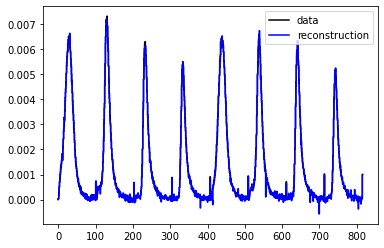

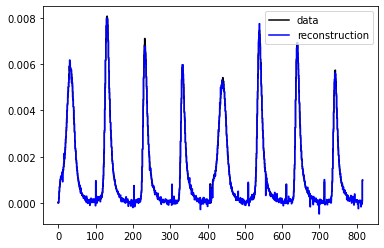

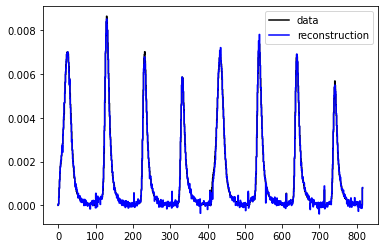

examples of bad histograms and reconstruction:


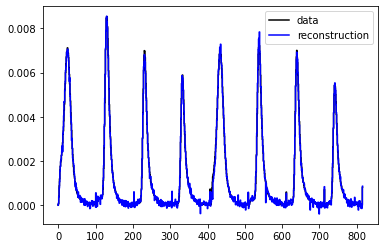

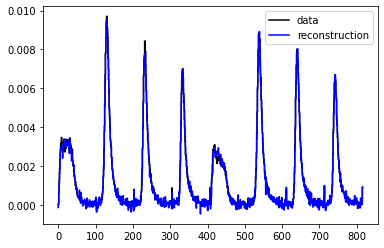

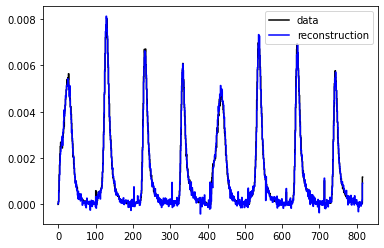

In [64]:
### impose a mse upper boundary and plot random examples of passing and failing histograms
# note: at this point, only the training set is considered!
# for a test set: see cell below.

cutvalue = mean + 3*std
#cutvalue = 4.73e-6
print('The mse threshold is: '+str(cutvalue))
goodindices = np.arange(0,len(mseTrain))[mseTrain<cutvalue]
badindices = np.arange(0,len(mseTrain))[mseTrain>cutvalue]

#test
#print(goodindices)
#print(badindices)
#end test

print('Number of passing histograms: '+str(len(goodindices)))
print('Number of failing histograms: '+str(len(badindices)))

nplot = 3
print('examples of good histograms and reconstruction:')
randint = np.random.choice(goodindices,size=nplot,replace=False)

for i in randint: 
    histlist = [X_train[int(i),:],predictionTrain[int(i),:]]
    labellist = ['data','reconstruction']
    colorlist = ['black','blue']
    pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
    plt.show()

print('examples of bad histograms and reconstruction:')
randint = np.random.choice(badindices,size=nplot,replace=False)
for i in randint:
    histlist = [X_train[int(i),:],predictionTrain[int(i),:]]
    labellist = ['data','reconstruction']
    colorlist = ['black','blue']
    pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
    plt.show()

average mse on good set: 3.261241570304527e-07
average mse on bad set: 1.085124911484496e-06
examples of good histograms and reconstruction:


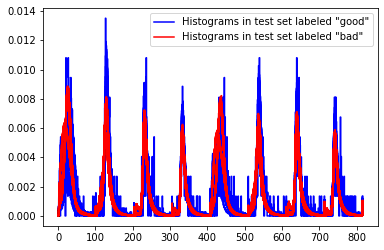

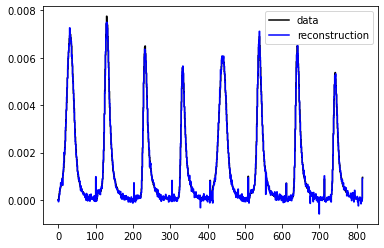

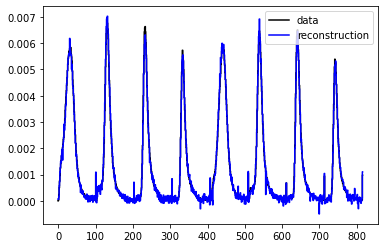

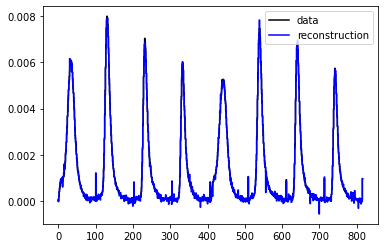

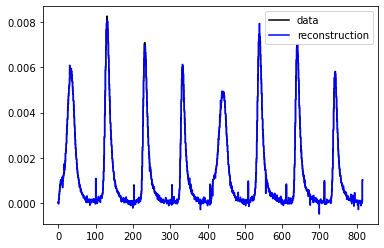

examples of bad histograms and reconstruction:


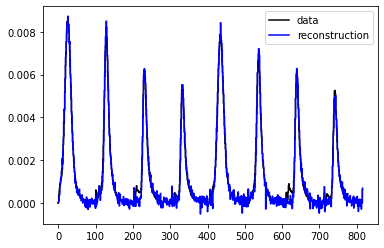

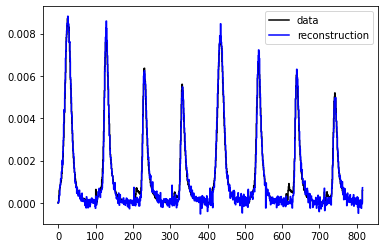

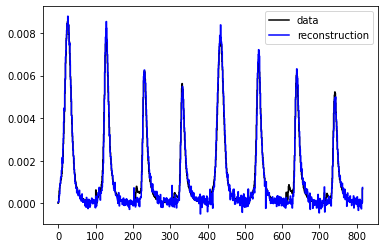

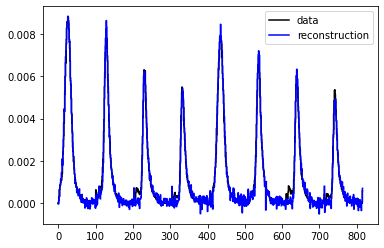

In [73]:
### get a test set and evaluate the model

goodrunsls = { #"297056":[[-1]],
                #"297177":[[-1]],
                #"301449":[[-1]]  
                "297050":[[-1]],
                "297474":[[-1]],
                "299000":[[-1]],
                "297057":[[-1]],
                "297177":[[-1]],
                "297296":[[-1]]
             }
badrunsls = {
               # "297048":[[-1]],
                #"297282":[[-1]],
                #"297283":[[-1]],
                #"297284":[[-1]],
                #"297287":[[-1]],
                #"297288":[[-1]],
                #"297289":[[-1]],
                #"299316":[[-1]],
                #"299317":[[-1]],
                #"299318":[[-1]],
                #"299324":[[-1]],
                #"299326":[[-1]],
                #"301086":[[88,126]],
                #"301086":[[89,89]],
                #"303948":[[1710,1710]],
               # "297047":[[-1]],
                #"297169":[[-1]],
                #"297211":[[-1]],
               "299325":[[-1]],
                "297664":[[-1]],
                "299317":[[-1]]
               # "297169":[[-1]]
            }

df = dfu.select_runs(df1,[297050,  297474, 299000, 299317,297047,
                297169,
                297211,
                299325,
                297664, 297057,
                297177,
                297296])
                      
df = dfu.select_dcson(df)


X_test_good = hu.preparedatafromdf( dfu.select_runsls(df,goodrunsls),donormalize=True )
X_test_bad = hu.preparedatafromdf( dfu.select_runsls(df,badrunsls),donormalize=True )

pu.plot_sets([X_test_good,X_test_bad],colorlist=['b','r'],
             labellist=['Histograms in test set labeled "good"','Histograms in test set labeled "bad"'])

prediction_test_good = autoencoder.predict(X_test_good)
mse_test_good = aeu.mseTopNRaw(X_test_good, prediction_test_good, n=10 )
prediction_test_bad = autoencoder.predict(X_test_bad)
mse_test_bad = aeu.mseTopNRaw(X_test_bad, prediction_test_bad, n=10 )

print('average mse on good set: '+str(np.mean(mse_test_good)))
print('average mse on bad set: '+str(np.mean(mse_test_bad)))

nplot = 4
print('examples of good histograms and reconstruction:')
randint = np.random.choice(np.arange(len(X_test_good)),size=nplot,replace=False)
for i in randint: 
    histlist = [X_test_good[int(i),:],prediction_test_good[int(i),:]]
    labellist = ['data','reconstruction']
    colorlist = ['black','blue']
    pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
    plt.show()

print('examples of bad histograms and reconstruction:')
randint = np.random.choice(np.arange(len(X_test_bad)),size=nplot,replace=False)
for i in randint:
    histlist = [X_test_bad[int(i),:],prediction_test_bad[int(i),:]]
    labellist = ['data','reconstruction']
    colorlist = ['black','blue']
    pu.plot_hists(histlist,colorlist=colorlist,labellist=labellist)
    plt.show()

number of good histograms: 291240
number of bad histograms: 30840


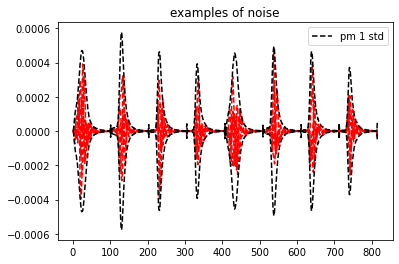

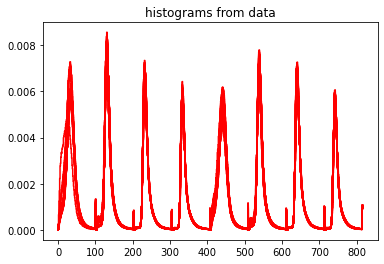

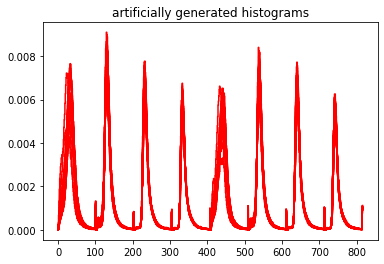

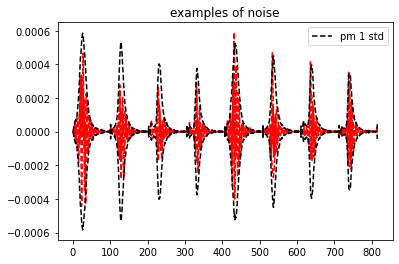

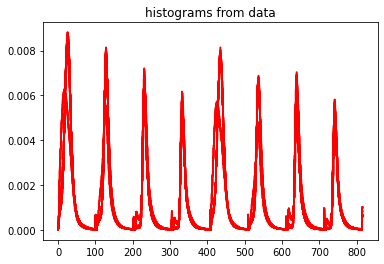

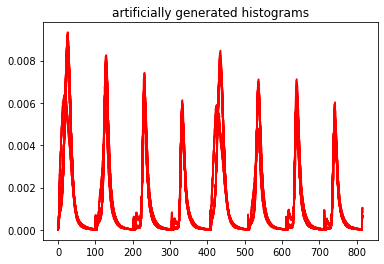

In [77]:
### use artificial data to assess the model performance

goodhists = gdu.fourier_noise(X_test_good,nresamples=120,nonnegative=True,stdfactor=15.,figname='f')
badhists = gdu.fourier_noise(X_test_bad,nresamples=120,nonnegative=True,stdfactor=15.,figname='f')
print('number of good histograms: '+str(len(goodhists)))
print('number of bad histograms: '+str(len(badhists)))

examples of artificial histograms and reconstruction:
[3.67725154e-07 3.35906032e-07 5.09672093e-07 ... 3.27998889e-07
 3.27123488e-07 4.16852064e-07]
[7.88162428e-07 7.94443382e-07 2.81084516e-06 ... 7.48685215e-07
 1.34079698e-06 8.02501226e-07]


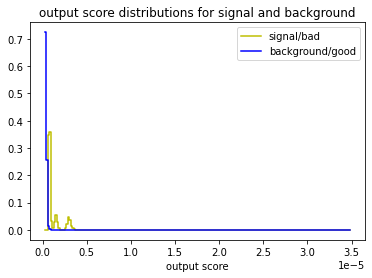

1.1637408571773552e-06
3.907475545283393e-07


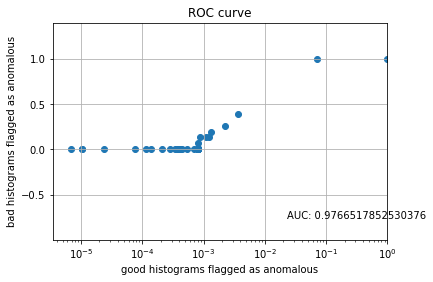

In [78]:
validation_data = np.vstack((goodhists,badhists))
labels = np.hstack((np.zeros(len(goodhists)),np.ones(len(badhists))))
prediction = autoencoder.predict(validation_data)
mse = aeu.mseTopNRaw(validation_data, prediction, n=10 )
print('examples of artificial histograms and reconstruction:')
shuffled_indices = np.arange(len(validation_data))
_ = np.random.shuffle(shuffled_indices)
validation_data = validation_data[shuffled_indices]
labels = labels[shuffled_indices]
prediction = prediction[shuffled_indices]
mse = mse[shuffled_indices]
print(mse[np.where(labels==0)])
print(mse[np.where(labels==1)])

# distribution of output scores


plot = pu.plot_score_dist(mse,labels,nbins=200,normalize=True)
plot[1].legend()
plt.savefig(name+'_signalBackground.png')
plt.show()
print(np.average(mse[np.where(labels==1)]))
print(np.average(mse[np.where(labels==0)]))
# classical ROC curve: signal efficiency (good data marked as good) vs background efficiency (bad data marked as good)

auc = aeu.get_roc(mse, labels)
plt.savefig(name+'_auc.png')
plt.show()

7.772442058528473e-07
Accuracy:   0.9513350720317933
misclassification rate:   0.04866492796820666


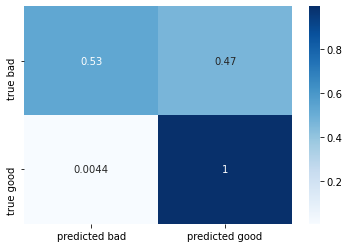

In [79]:
### continution of previous cell: choose wp and plot confusion matrix

msewp = abs((np.average(mse[np.where(labels==1)])+np.average(mse[np.where(labels==0)]))/2)
print(msewp)
aeu.get_confusion_matrix_from_hists(validation_data,labels,prediction,msewp)
plt.savefig(name+'_confusion.png')

